# PipLine of Submission

- model part: 'train' data loading, model training
- predict: prediction result
- save: save prediction in appropriate format

In [38]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

- combine train dataset & validate dataset to new 'train' data

In [2]:
data_df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val_df = pd.read_csv('data/mid_res/20210526_val_df.csv')
df = pd.concat([data_df, val_df], axis = 0)

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [4]:
test_ratio = 0.2
X = df.drop(col_drop_x + col_drop, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, df[col_label], test_size = test_ratio)

# Model

In [5]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test) # label predict
pred_prob_rf = model_rf.predict_proba(X_test) # prob predict

[[25961  2752    68   244   418  1307  2252  1776]
 [ 1095 23327  1657   909   199   473   164   125]
 [    8   486  5713   215    12    14     1     0]
 [  185   752  1434 21013  2527  1806   459   229]
 [   37    56     7   752 25515  2380  3373   781]
 [  352   613   207  2153  3953 21662  4319  2154]
 [  859   614     6    89  3169  2180 23969  2058]
 [ 2000  1212     3   295    81   274  1300 20893]]
              precision    recall  f1-score   support

       Still       0.85      0.75      0.80     34778
     Walking       0.78      0.83      0.81     27949
         Run       0.63      0.89      0.74      6449
        Bike       0.82      0.74      0.78     28405
         Car       0.71      0.78      0.74     32901
         Bus       0.72      0.61      0.66     35413
       Train       0.67      0.73      0.70     32944
      Subway       0.75      0.80      0.77     26058

    accuracy                           0.75    224897
   macro avg       0.74      0.77      0.75    22

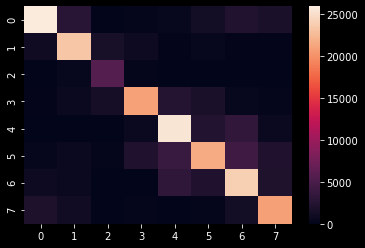

In [6]:
helper.evaluate(pred_rf, y_test)

# Test Data

In [12]:
# test = DataLoader.SHLDataLoader('data/test/', ratio = None)
# test.load_all()
# dp = DataProcesser.DataProcesser(test)
# dp.process_pipe()
# test_time = pd.read_table('data/example_submission/teamName_predictions.txt', header = None, names = ['time', 'label'], sep = "\t")['time']
# test.df = pd.merge(test_time, test.df, on = ['time'], how = 'left')
with open('data/mid_res/test.pickle', 'rb') as f:  
    test = pickle.load(f)

In [16]:
X_test = test.df.drop(['time'] + col_drop, axis = 1).fillna(0)

In [70]:
pred = pd.Series(model_rf.predict(X_test))
pred_mode = pred.rolling(120, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [76]:
def save_prediction(pred_time, pred_res, file_path = 'data/RY_predictions.txt'):
    res = pd.DataFrame({'time': pred_time, 'label': pred_res})
    res.to_csv(file_path, index = False, header = False, sep = '\t')

In [75]:
save_prediction(test.df.time, pred, 'data/RY_predictions.txt')

In [66]:
df_tmp = data_df.copy()
df_tmp['tmp'] = df_tmp[['num_wifi', 'altitude', 'num_gps', 'num_cells']].isnull().sum(axis = 1)
[(t[0], t[1]/sum([t[1] for t in Counter(df_tmp['tmp']).most_common()])) for t in Counter(df_tmp['tmp']).most_common()]

[(0, 0.6005994735484081),
 (1, 0.26473416846246967),
 (2, 0.12117055420197506),
 (3, 0.012028225637845771),
 (4, 0.0014675781493013451)]

In [77]:
# plt.figure(figsize = [20, 8])
# plt.plot(pred_mode)